In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Thu Jan 11 22:18:17 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   36C    P2    64W / 230W |   3954MiB / 23028MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-18/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 37388
-rw-rw-r-- 1 scpark scpark   306788  1월 11 22:18 events.out.tfevents.1704978331.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37973949  1월 11 22:05 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=1024, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


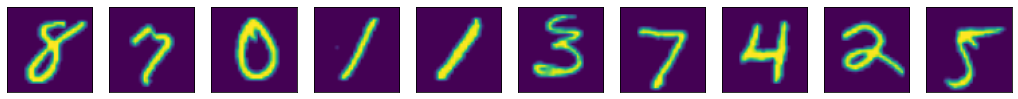

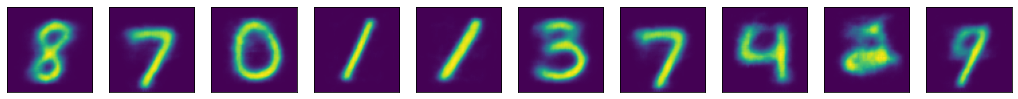

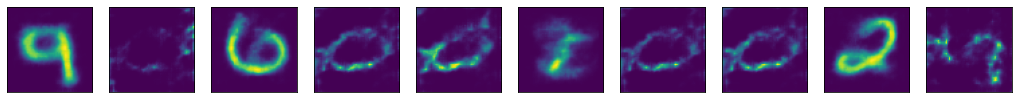

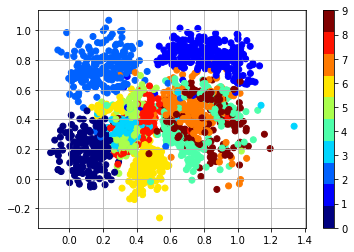

2001
lse_loss 0.00025759724667295814
recon_loss 0.117012158036232
2002
lse_loss 0.00037418148713186383
recon_loss 0.1193031519651413
2003
lse_loss 0.00043980544432997704
recon_loss 0.11693670600652695
2004
lse_loss 0.0003386258031241596
recon_loss 0.11549465358257294
2005
lse_loss 0.00010485491657163948
recon_loss 0.12248951941728592
2006
lse_loss 0.00023012282326817513
recon_loss 0.1194273829460144
2007
lse_loss 0.00024338869843631983
recon_loss 0.11837821453809738
2008
lse_loss 0.000326987006701529
recon_loss 0.11813592910766602
2009
lse_loss 0.0003051671665161848
recon_loss 0.12059756368398666
2010
lse_loss 0.00027978187426924706
recon_loss 0.11653807014226913
2011
lse_loss 0.0003386770258657634
recon_loss 0.11436043679714203
2012
lse_loss 0.00020584418962243944
recon_loss 0.11559109389781952
2013
lse_loss 0.0004375548451207578
recon_loss 0.1223258227109909
2014
lse_loss 0.00012807376333512366
recon_loss 0.11995287239551544
2015
lse_loss 0.00036131191882304847
recon_loss 0.117759466

2124
lse_loss 0.00014793015725445002
recon_loss 0.11632444709539413
2125
lse_loss 0.00015847392205614597
recon_loss 0.11856931447982788
2126
lse_loss 0.00011155592073919252
recon_loss 0.11196993291378021
2127
lse_loss 0.00015096523566171527
recon_loss 0.11566957086324692
2128
lse_loss 0.0002101835561916232
recon_loss 0.11839623749256134
2129
lse_loss 0.0001863004290498793
recon_loss 0.11313124746084213
2130
lse_loss 9.842000144999474e-05
recon_loss 0.11302255839109421
2131
lse_loss 6.41050428384915e-05
recon_loss 0.11492409557104111
2132
lse_loss 0.00020768203830812126
recon_loss 0.1195085346698761
2133
lse_loss 0.00012570711260195822
recon_loss 0.11412113904953003
2134
lse_loss 0.00027786334976553917
recon_loss 0.1220155879855156
2135
lse_loss 0.00017657193529885262
recon_loss 0.11662419885396957
2136
lse_loss 0.00016751099610701203
recon_loss 0.11988412588834763
2137
lse_loss 0.00018713758618105203
recon_loss 0.11449521034955978
2138
lse_loss 8.472556510241702e-05
recon_loss 0.122477

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        